In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix
import itertools

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder

In [2]:
df_online = pd.read_csv("./NatRep_Online_Upload.csv", delimiter = ",")
df_phone = pd.read_csv("./NatRep_Phone_upload.csv", delimiter = ",")

In [3]:
df_online.head()

,ID,Voting_Intention,EUREF_Int,EUREF_SQUEEZE,EUREF_likely,Optimism,Immigration,political_attention,Newspaper_Often,Newspaper_Read,...,socialgrade_single,socialgrade_matrix,education_age,profile_education_level,pvbyregion_w8,bpcagegeneduc_w8,Socgrade_matrix_w8,threeway_attention_w8,respdate,W8
0,1,1,1,9,11,3,3,8,2,99,...,1,4,5,16,21,5,3,2,5/7/2016,1.073793
1,2,9,2,9,11,3,3,8,2,99,...,1,2,4,15,20,12,1,2,4/30/2016,0.950170
2,3,4,2,9,11,1,2,9,1,7,...,2,3,3,9,1,10,2,3,4/29/2016,0.835697
3,4,1,1,9,11,3,2,1,2,99,...,2,6,2,1,1,1,4,1,5/9/2016,1.235505
4,5,2,1,9,11,4,3,6,1,4,...,1,3,3,11,8,15,2,2,5/11/2016,0.895797


In [4]:
df_phone.head()

,ID,Phone_Type,Voting_Intention,EUREF_Int,EUREF_SQUEEZE,EUREF_likely,Optimism,Immigration,political_attention,Newspaper_Often,...,socialgrade_single,education_age,education_ageR,Education_still,pvbyregion_w8,bpcagegeneduc_w8,socgrade_single_w8,threeway_attention_w8,respdate,W8
0,3913,1,1,2,,11,1,3,6,1,...,1,,,,17,10,1,2,5/7/2016,0.266450
1,3530,1,7,3,3,6,1,2,6,1,...,1,13,1,,22,16,1,2,5/10/2016,0.726617
2,3356,1,8,3,3,11,1,2,7,2,...,1,14,1,,1,10,1,2,5/4/2016,0.987820
3,3658,1,1,2,,11,1,2,11,1,...,1,14,1,,1,10,1,3,5/9/2016,0.549106
4,3240,1,2,3,3,6,3,1,1,1,...,1,14,1,,2,10,1,1,5/9/2016,1.301435


In [5]:
df_phone_dummies = pd.get_dummies(df_phone)
df_phone_dummies.head()

,ID,Phone_Type,Voting_Intention,EUREF_Int,EUREF_likely,Optimism,Immigration,political_attention,Newspaper_Often,TV_News,...,respdate_5/11/2016,respdate_5/12/2016,respdate_5/2/2016,respdate_5/3/2016,respdate_5/4/2016,respdate_5/5/2016,respdate_5/6/2016,respdate_5/7/2016,respdate_5/8/2016,respdate_5/9/2016
0,3913,1,1,2,11,1,3,6,1,2,...,0,0,0,0,0,0,0,1,0,0
1,3530,1,7,3,6,1,2,6,1,2,...,0,0,0,0,0,0,0,0,0,0
2,3356,1,8,3,11,1,2,7,2,1,...,0,0,0,0,1,0,0,0,0,0
3,3658,1,1,2,11,1,2,11,1,1,...,0,0,0,0,0,0,0,0,0,1
4,3240,1,2,3,6,3,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1


In [6]:
df_online_dummies = pd.get_dummies(df_online)
df_online_dummies.head()

,ID,Voting_Intention,EUREF_Int,EUREF_SQUEEZE,EUREF_likely,Optimism,Immigration,political_attention,Newspaper_Often,Newspaper_Read,...,respdate_5/11/2016,respdate_5/12/2016,respdate_5/2/2016,respdate_5/3/2016,respdate_5/4/2016,respdate_5/5/2016,respdate_5/6/2016,respdate_5/7/2016,respdate_5/8/2016,respdate_5/9/2016
0,1,1,1,9,11,3,3,8,2,99,...,0,0,0,0,0,0,0,1,0,0
1,2,9,2,9,11,3,3,8,2,99,...,0,0,0,0,0,0,0,0,0,0
2,3,4,2,9,11,1,2,9,1,7,...,0,0,0,0,0,0,0,0,0,0
3,4,1,1,9,11,3,2,1,2,99,...,0,0,0,0,0,0,0,0,0,1
4,5,2,1,9,11,4,3,6,1,4,...,1,0,0,0,0,0,0,0,0,0


In [7]:
y_df_phone_dummies = df_phone_dummies["Voting_Intention"].copy()

In [8]:
y_df_phone_dummies["id"]=range(1,len(df_phone_dummies)+1)

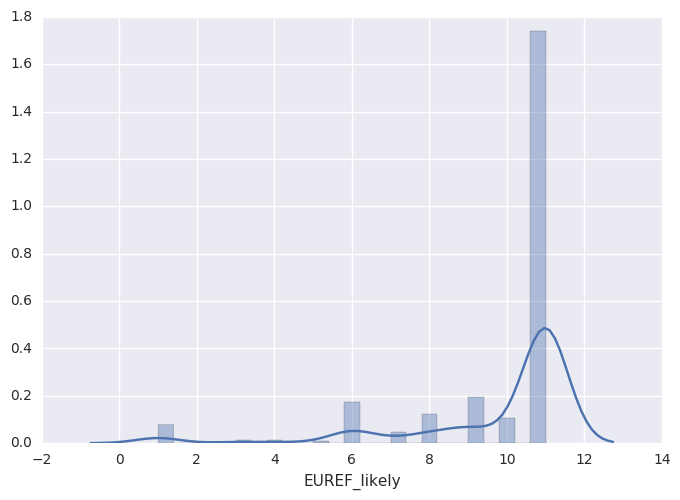

In [9]:
sns_plot = sns.distplot(df_phone_dummies["EUREF_likely"])

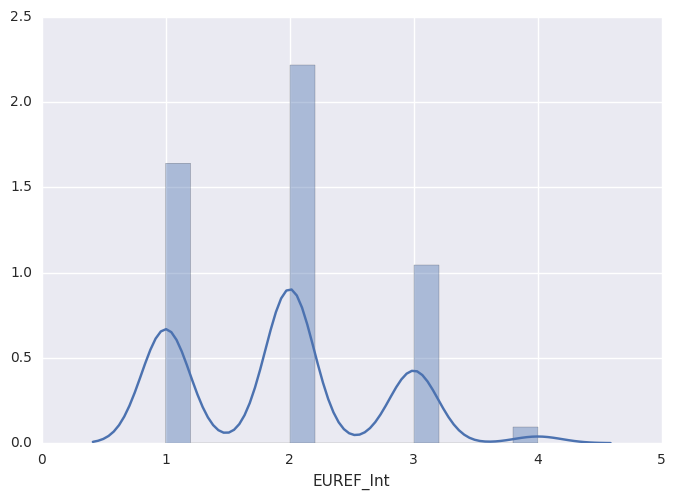

In [14]:
sns_plot = sns.distplot(df_phone_dummies["EUREF_Int"])

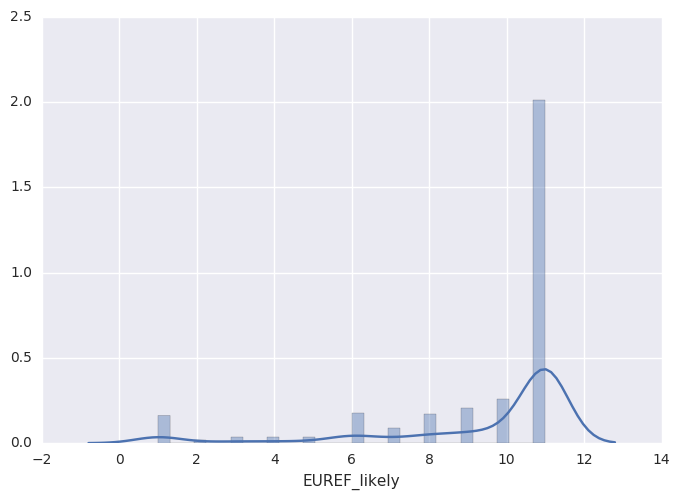

In [12]:
sns_plot = sns.distplot(df_online_dummies["EUREF_likely"])

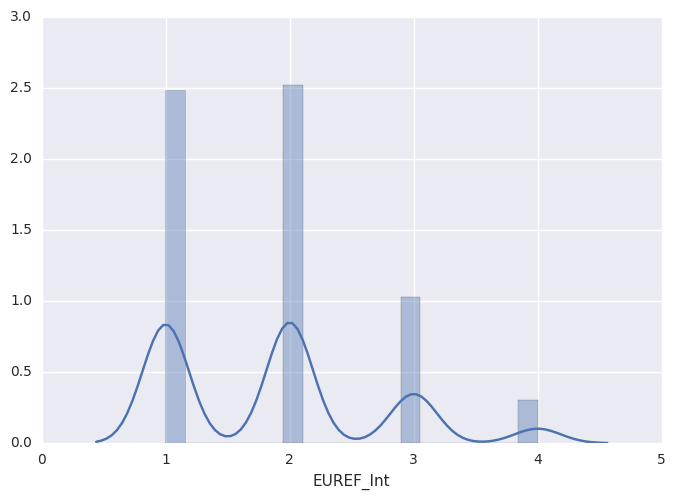

In [13]:
sns_plot = sns.distplot(df_online_dummies["EUREF_Int"])